# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

### <font color='purple'>Answer 1:</font>
   - 8 campaigns that occurred between May 2008 and November 2010, corresponding to a total of 79354 contacts.
   - This bank marketing dataset represents eight marketing campaigns. The paper mentions that the data was collected from May 2008 to November 2010, and there is a column in the dataset called previous which indicates the number of contacts performed before this campaign and for this client. This suggests that there were at least eight marketing campaigns, since the previous column can be up to 7.

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import time
import statsmodels.api as sm

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, classification_report

In [2]:
# Load the data
df = pd.read_csv('data/bank-additional-full.csv', sep = ';')

In [3]:
# Print top 5 records
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



### <font color='purple'>Explanatory Data Analysis:</font>

In [4]:
# Extract Categorical Features
categorical_features = df.describe(include=["object"]).columns
# Extract Numerical Features
numerical_features = df.describe().columns

In [5]:
categorical_features

Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'day_of_week', 'poutcome', 'y'],
      dtype='object')

In [6]:
numerical_features

Index(['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed'],
      dtype='object')

### <font color='purple'>Observations:</font>
   - The data consists of 10 numerical & 11 categorical features

In [7]:
df.shape

(41188, 21)

### <font color='purple'>Observations:</font>
   - The dataset has 41188 rows and 21 columns.

In [8]:
# Summarize the distribution of the numerical features in the dataset
df[numerical_features].describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


### <font color='purple'>Observations:</font>

   - Age: 17-98 years old
   - Number of contacts during this campaign: 1-56
   - Days since last contacted: 0-999
   - Number of contacts before this campaign: 0-7
   - The data shows that the customer base is quite diverse in terms of age.
   - There is a wide range in the number of contacts made during this campaign, suggesting that some customers were more responsive than others.

In [9]:
# Summarize the distribution of the categorical features in the dataset
df[categorical_features].describe()

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome,y
count,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188
unique,12,4,8,3,3,3,2,10,5,3,2
top,admin.,married,university.degree,no,yes,no,cellular,may,thu,nonexistent,no
freq,10422,24928,12168,32588,21576,33950,26144,13769,8623,35563,36548


### <font color='purple'>Observations:</font>

   - The majority of the customers in the dataset are employed and married.
   - The most common level of education is a university degree.
   - Most customers do not have a default on their loan or housing.
   - The most common contact method is cellular, and the most common month and day of week for contact are May and Thursday.
   - The majority of customers have not participated in a previous marketing campaign.
   - The target variable (y) is not balanced, with only 4640 customers (11.2%) responding positively to the marketing campaign.


In [10]:
# Extracting the unique values from categorical features
for column in categorical_features:
    print(f"{column}:      {df[column].unique()}")

job:      ['housemaid' 'services' 'admin.' 'blue-collar' 'technician' 'retired'
 'management' 'unemployed' 'self-employed' 'unknown' 'entrepreneur'
 'student']
marital:      ['married' 'single' 'divorced' 'unknown']
education:      ['basic.4y' 'high.school' 'basic.6y' 'basic.9y' 'professional.course'
 'unknown' 'university.degree' 'illiterate']
default:      ['no' 'unknown' 'yes']
housing:      ['no' 'yes' 'unknown']
loan:      ['no' 'yes' 'unknown']
contact:      ['telephone' 'cellular']
month:      ['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'mar' 'apr' 'sep']
day_of_week:      ['mon' 'tue' 'wed' 'thu' 'fri']
poutcome:      ['nonexistent' 'failure' 'success']
y:      ['no' 'yes']


In [11]:
# how many people have subscribed to a term deposit?
# Let's check whether the dataset is balanced or imbalanced
df.y.value_counts() 

y
no     36548
yes     4640
Name: count, dtype: int64

### <font color='purple'>Observations:</font>
   - 4640 (11.2%) people have subscribed to a term deposit.
   - 36548 (88.7%) people have not subscribed to a term deposit.

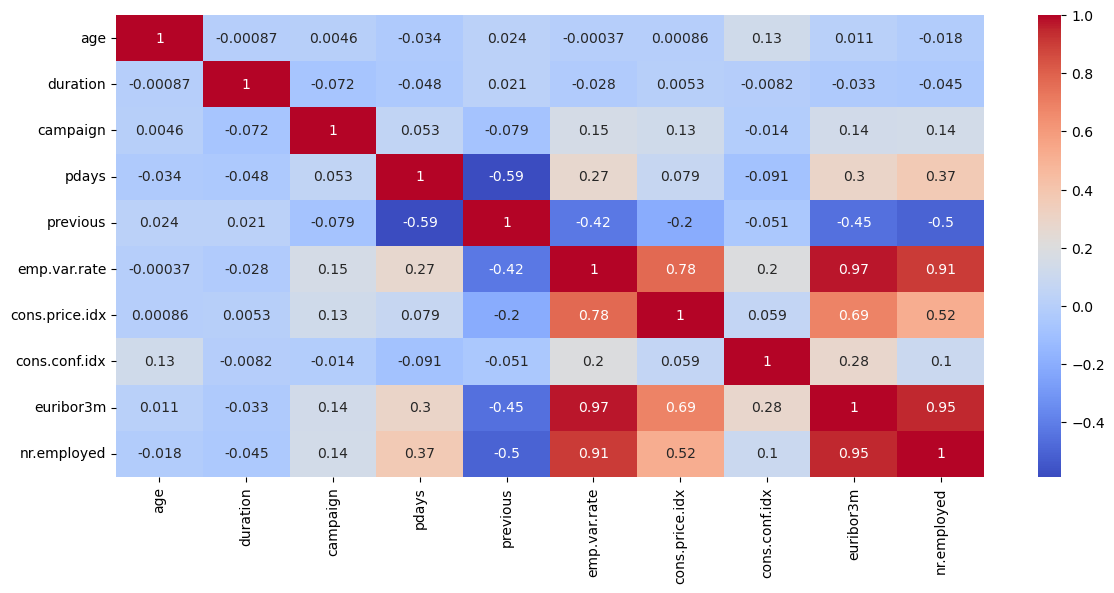

In [12]:
# Heatmap of numerical features
# Set the size of the plot
plt.figure(figsize=(14, 6))
# df.corr(numeric_only=True).style.background_gradient(cmap='coolwarm')
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
# Save the plot as an image
plt.savefig("images/heatmap_numeric_features.png")
plt.show()

### <font color='purple'>Observations:</font>
   
   - Strong positive correlation pairs:

        - emp.var.rate and nr.employed
        - emp.var.rate and euribor3m
        - euribor3m and nr.employed
        - cons.price.idx and emp.var.rate
        - cons.price.idx and euribor3m

   - This suggests that economic growth (measured by emp.var.rate and nr.employed) is associated with higher interest rates (measured by euribor3m) and inflation (measured by cons.price.idx).

   - Strong negative correlation pairs:

        - pdays and previous
        - previous and emp.var.rate
        - previous and euribor3m
        - previous and nr.employed

   - This suggests that customers who have defaulted on previous loans are more likely to default on future loans, and that customers who are unemployed are more likely to default on loans.

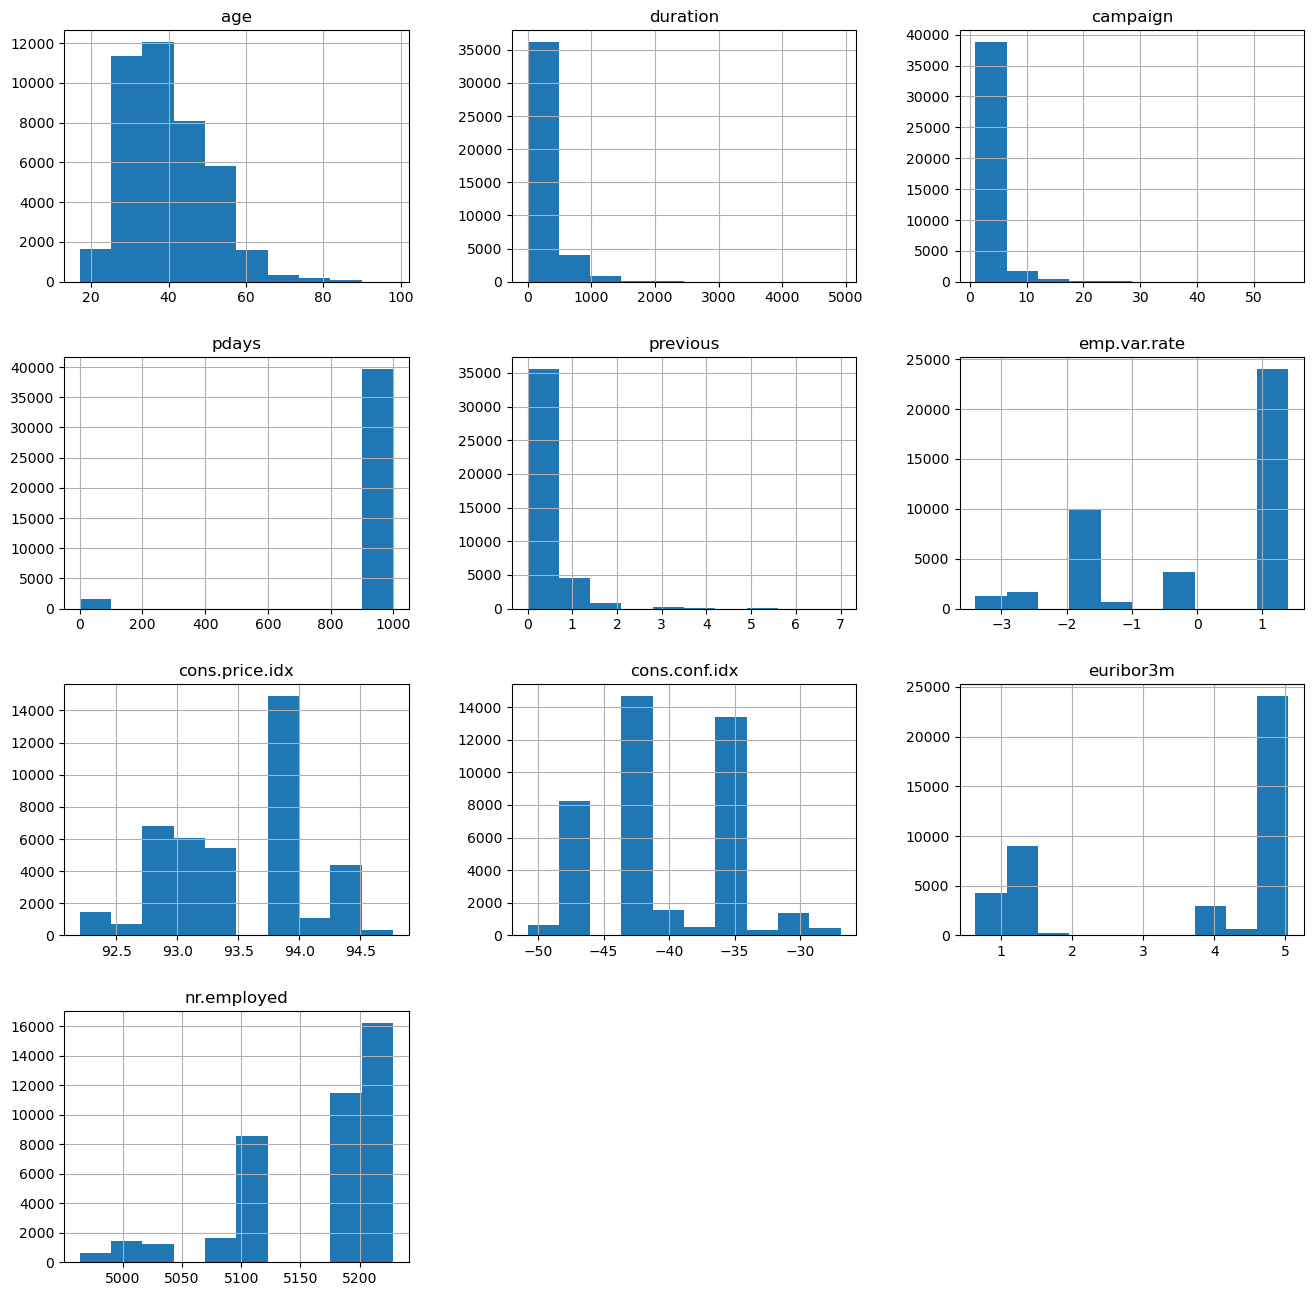

In [13]:
_ = df.hist(column=numerical_features, figsize = (16,16))
# Save the figure
plt.savefig("images/histogram_numeric_features.png")

### <font color='purple'>Observations:</font>
   
   - The Average customer is 38 years old and has a loan duration of 287 days. The average customer has participated in 2.76 campaigns and has 0.73 previous loans. 
   - The average unemployment rate is 1% and the average consumer price index is 93.69. The average consumer confidence index is -38.13 and the average Euribor3m rate is 3.64%.

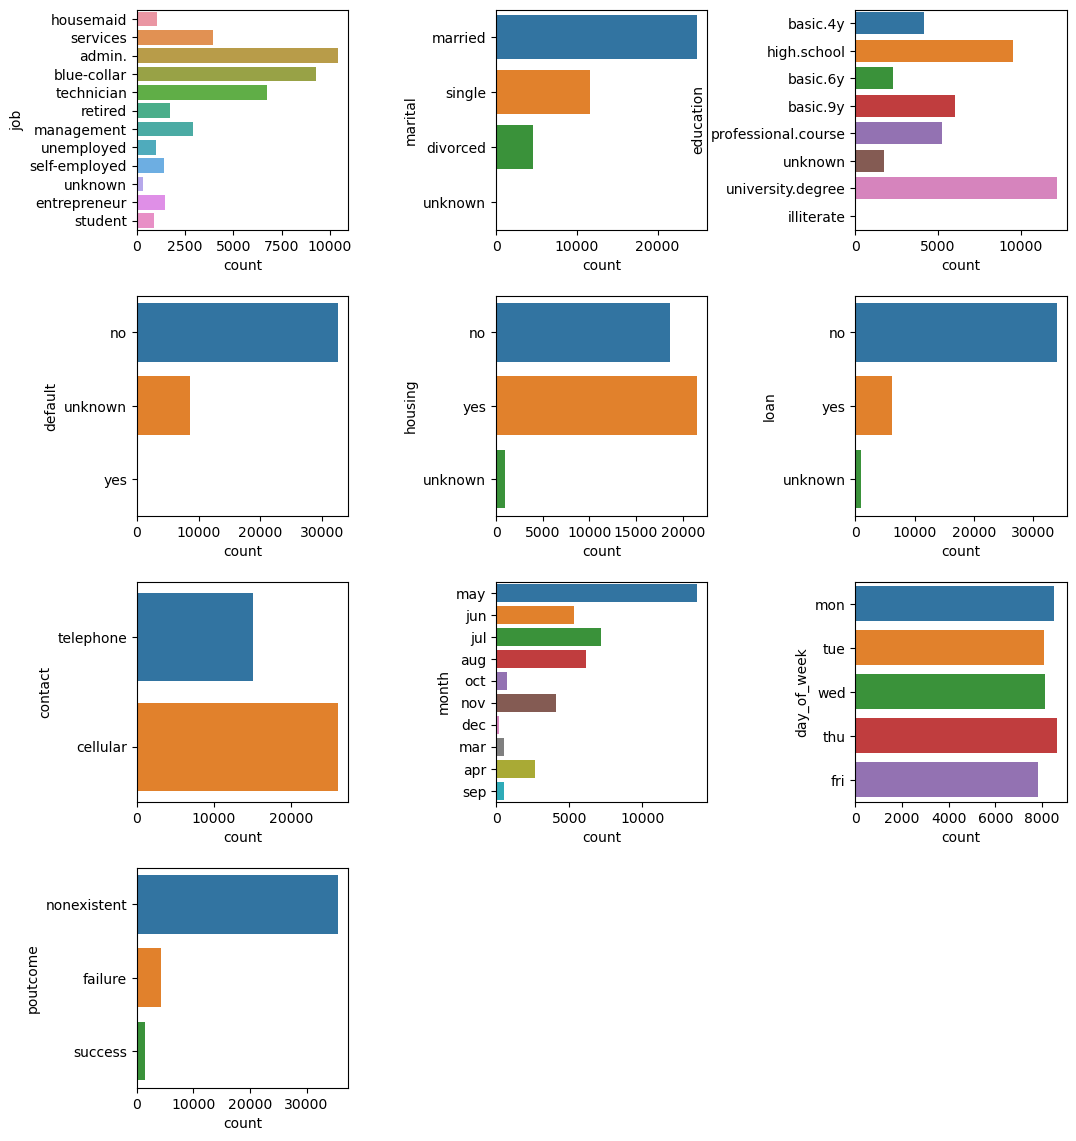

In [14]:
# Count plots of categorical features
fig, axes = plt.subplots(4, 3, figsize=(12, 14))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.7, hspace=0.3)

for i, ax in enumerate(axes.ravel()):
    if i > 9:
        ax.set_visible(False)
        continue
    sns.countplot(y = categorical_features[i], data=df, ax=ax)
    
# Save the figure
plt.savefig("images/countplot_categorical_features.png")

### <font color='purple'>Observations:</font>
   
   - Majority of customers in the dataset are married, have a university degree, and own a home. 
   - Most customers also have a loan and are contacted by the bank via cellular phone. The most common month for contact is May, and the most common day of week for contact is Thursday. 
   - The majority of customers have not participated in a previous marketing campaign.

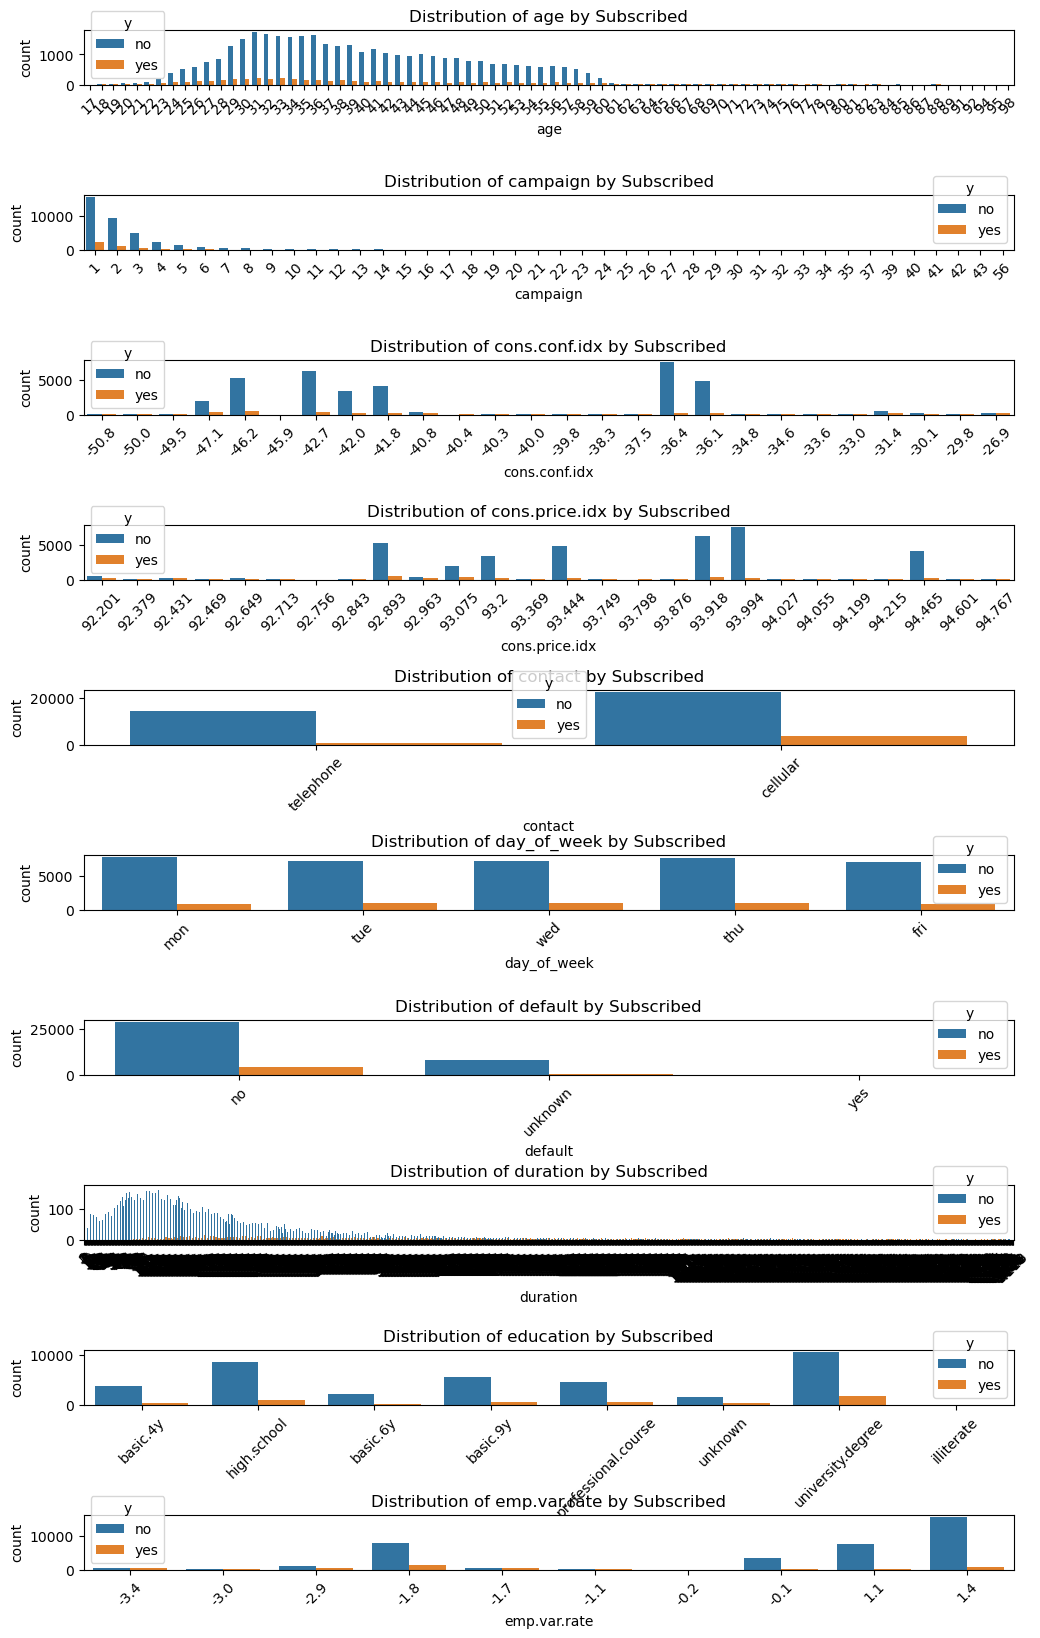

In [15]:
# Set the number of rows and columns for subplots
num_rows = 10
num_cols = 1
features = df.columns.difference(['y'])  # Exclude 'y' from features

plt.figure(figsize=(12, 20))

for i, feature in enumerate(features):
    if i < num_rows * num_cols:
        plt.subplot(num_rows, num_cols, i + 1)
        sns.countplot(data=df, x=feature, hue='y')
        plt.title(f'Distribution of {feature} by Subscribed')
        plt.xticks(rotation=45)    
        
plt.subplots_adjust(hspace=2)
# Save the figure
plt.savefig("images/subplots_all_features.png")
plt.show()

### <font color='purple'>Observations:</font>
   - More subscribed customers in the older age groups (50+).
   - More subscribed customers who have loans with a longer duration (300+ days).
   - More subscribed customers who have participated in more campaigns (3+).
   - Subscribed customers (pdays=0) have not defaulted on any previous loans. Non-subscribed customers (pdays>0) have defaulted on previous loans.
   - Subscribed customers (previous=0) have not taken out any previous loans. Non-subscribed customers (previous>0) have taken out a previous loan.
   - More subscribed customers who have a higher emp.var.rate (0.02+).

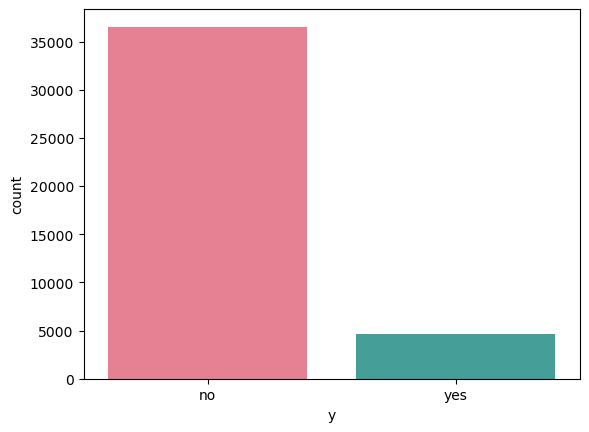

In [16]:
sns.countplot(x='y', data=df, palette ='husl')
# Save the figure
plt.savefig("images/countplot_y.png")

### <font color='purple'>Observations:</font>
- The data suffers from class imbalance, where the ‘no’ class is eight times more frequent than the ‘yes’ class, as shown in the above plot.
- When a dataset displays skewed or biased distributions of examples, this can result in a corresponding bias within the trained model, ultimately impairing its performance.

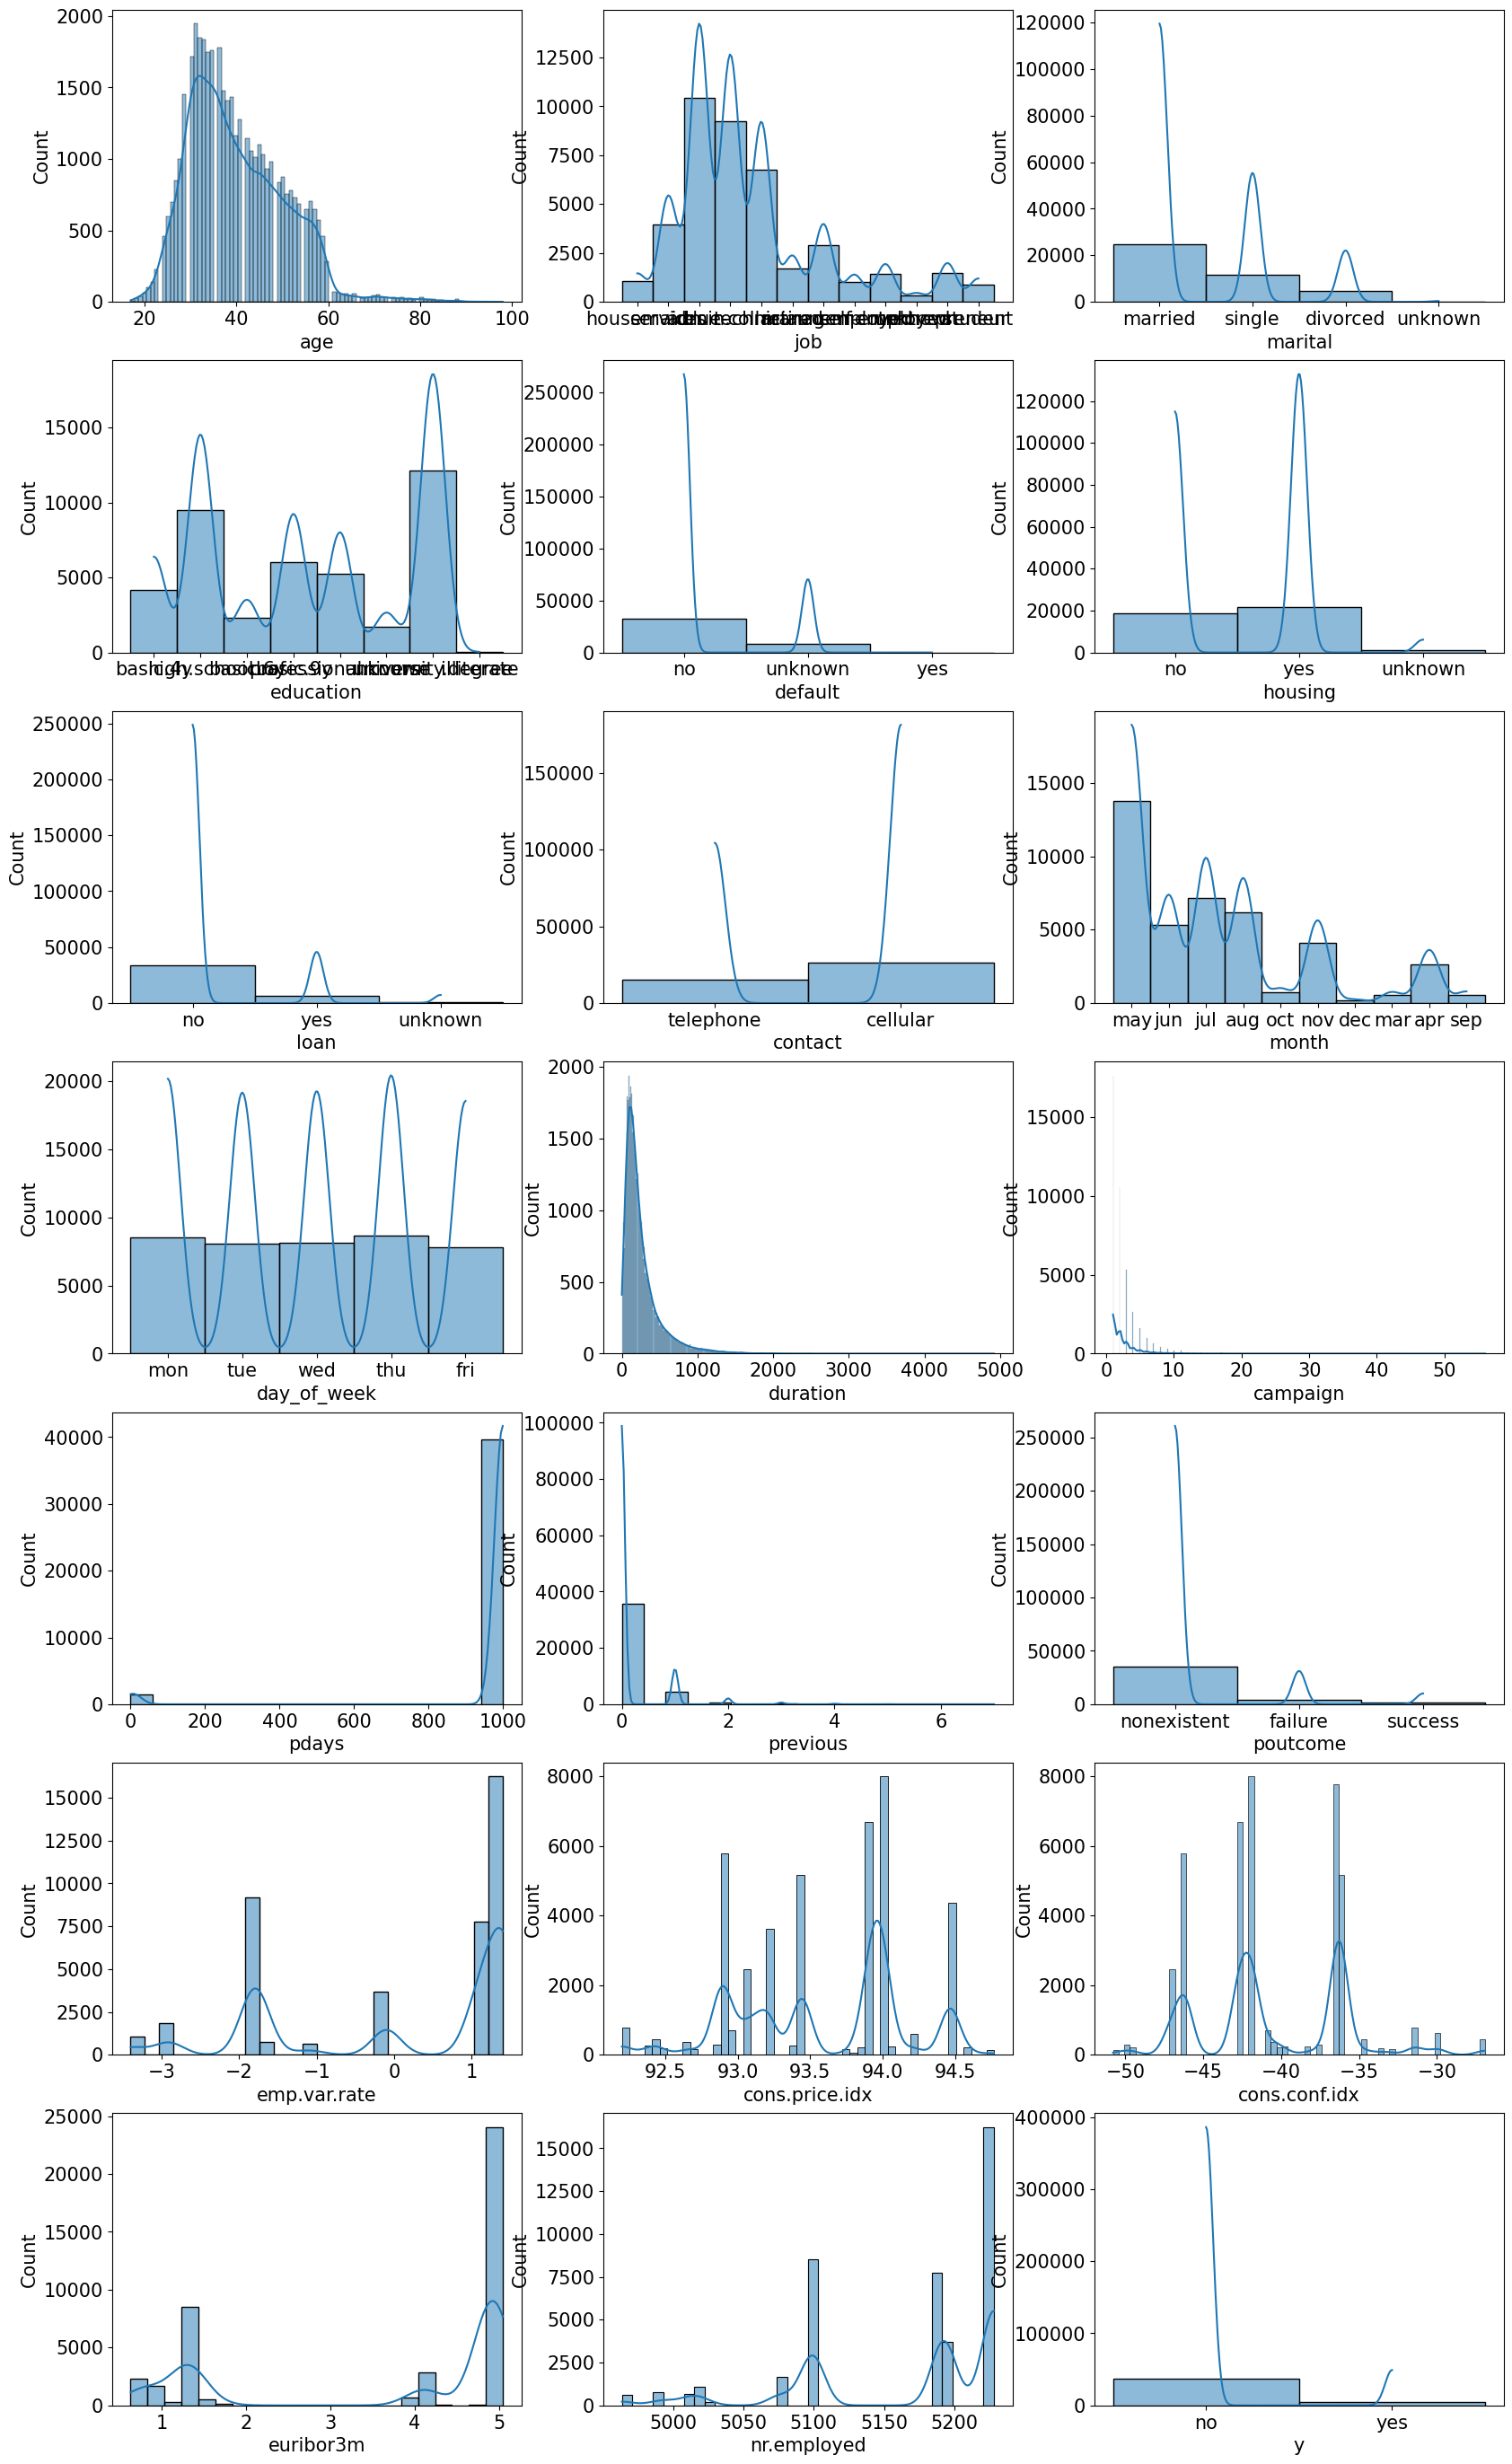

In [17]:
# plot of the histograms and KDE curves of the numerical features
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(20, 60), facecolor='white')
plotnumber = 1

for num_features in df.columns:
    ax = plt.subplot(12, 3, plotnumber)
    sns.histplot(df[num_features], kde=True)
    plt.xlabel(num_features)
    plotnumber += 1

# Save the figure
plt.savefig("images/histogram_all_kde.png")
plt.show()

In [18]:
# convert target column yes/no to 1/0
df['y'] = df['y'].map({'no':0, 'yes':1})
# Convert the target column to int type
df['y'] = df['y'].astype('int')

In [19]:
# Copy the data frame
df_copy = df.copy()

In [20]:
# Find missing values in the dataset
df_copy.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

In [21]:
# drop null values
df_copy.dropna(inplace = True)

In [22]:
# check for duplicate values 
duplicate_rows = df_copy.duplicated().sum()

# print duplicate rows
print("Duplicated Rows:", duplicate_rows)

Duplicated Rows: 12


In [23]:
# remove duplicate rows based on all columns
df_copy.drop_duplicates(inplace=True)

In [24]:
# Prints the number of unknown values for all the features
def print_unknown_values(df):
    print("Number of 'unknown' values in each feature:")
    for col in df.columns:
        print("'{}' : {}".format(col, len(df.loc[df[col] == "unknown"])))

# Usage
print_unknown_values(df_copy)

Number of 'unknown' values in each feature:
'age' : 0
'job' : 330
'marital' : 80
'education' : 1730
'default' : 8596
'housing' : 990
'loan' : 990
'contact' : 0
'month' : 0
'day_of_week' : 0
'duration' : 0
'campaign' : 0
'pdays' : 0
'previous' : 0
'poutcome' : 0
'emp.var.rate' : 0
'cons.price.idx' : 0
'cons.conf.idx' : 0
'euribor3m' : 0
'nr.employed' : 0
'y' : 0


In [25]:
# Drop rows with unknown marital status using `loc`
df_copy = df_copy.loc[df_copy['marital'] != 'unknown']

### <font color='purple'>Observations:</font>
   - Maritial status in the dataset has 80 unknown values, which is not logical since maritial status is always labeled as single, married, or divorced. 
   - The unknown labels will be removed from the dataset to ensure the accuracy of the data.

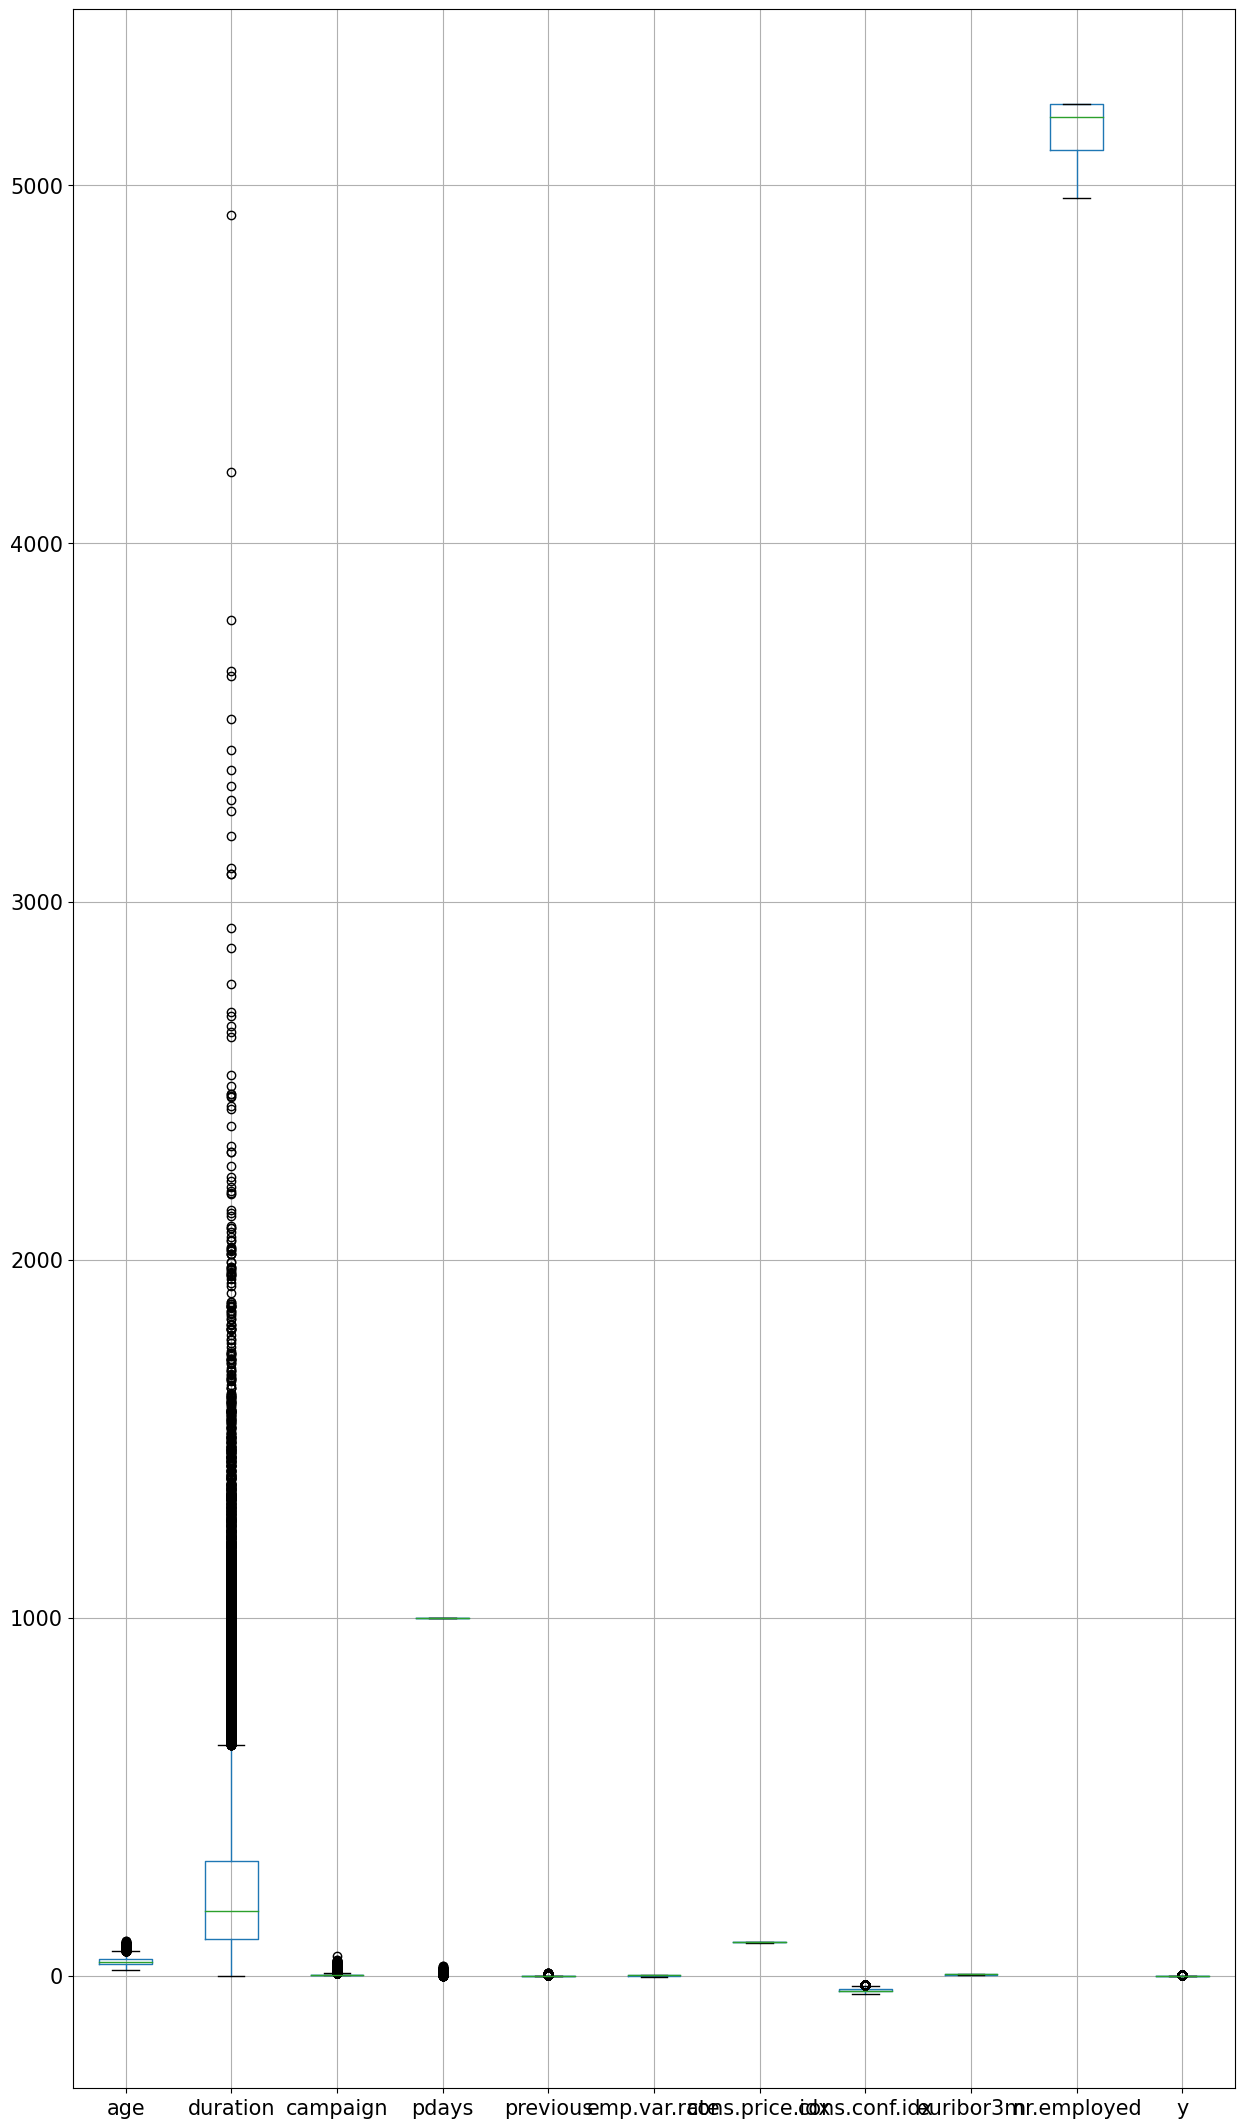

In [26]:
# Finding outliers in the dataset using Box Plot
plt.figure(figsize=(15,27))
df_copy.boxplot()
# Save the figure
plt.savefig("images/boxplot_outliers.png")

### <font color='purple'>Observations:</font>
   - Duration: Many outliers, likely due to the fact that the duration variable is measured in seconds.
   - Age: Some outliers, may be due to data entry errors or genuine outliers in the data.
   - Campaign: Some outliers, may be due to data entry errors or genuine outliers in the data.

In [27]:
def find_overlapped_features(dataframe, target_column, feature_columns):
    # Group the data and calculate the size of each group
    group_size = dataframe.groupby(feature_columns + [target_column]).size()
    
    # Group by the feature columns and count the number of target values
    feature_group_size = group_size.groupby(feature_columns).size().reset_index()
    
    # Select feature groups where the count of target values is greater than 1
    overlapped_features = feature_group_size[feature_group_size[0] > 1][feature_columns]
    
    return overlapped_features

# Example usage:
feature_columns = ['age', 'job', 'marital', 'education', 'default', 'housing', 'loan']
target_column = 'y'
overlapped_features = find_overlapped_features(df_copy, target_column, feature_columns)

In [28]:
def find_overlapped_features_size_and_percentage(df, df_size, columns):
    # Merge the two DataFrames on the common features.
    merged_df = df.merge(df_size, on=columns)

    # Calculate the overlapped features size and percentage.
    overlapped_features_size = len(merged_df)
    overlapped_features_percentage = overlapped_features_size / len(df)

    # Return the overlapped features size and percentage.
    return pd.DataFrame({'Overlapped Features Count': [overlapped_features_size],
                      'Overlapped Features Percentage': [overlapped_features_percentage]})

find_overlapped_features_size_and_percentage(df_copy, overlapped_features, feature_columns)

,Overlapped Features Count,Overlapped Features Percentage
0,19519,0.474961


In [29]:
# Apply label encoder on categorical features to convert to numeric.
categorical_features = categorical_features.drop('y')

# Apply Label Encoding to categorical columns
label_encoder = LabelEncoder()
df_copy[categorical_features] = df_copy[categorical_features].apply(
                                            lambda col: label_encoder.fit_transform(col) + 1)

In [30]:
# Drop duplicate records if any
df_copy.drop_duplicates(inplace=True)

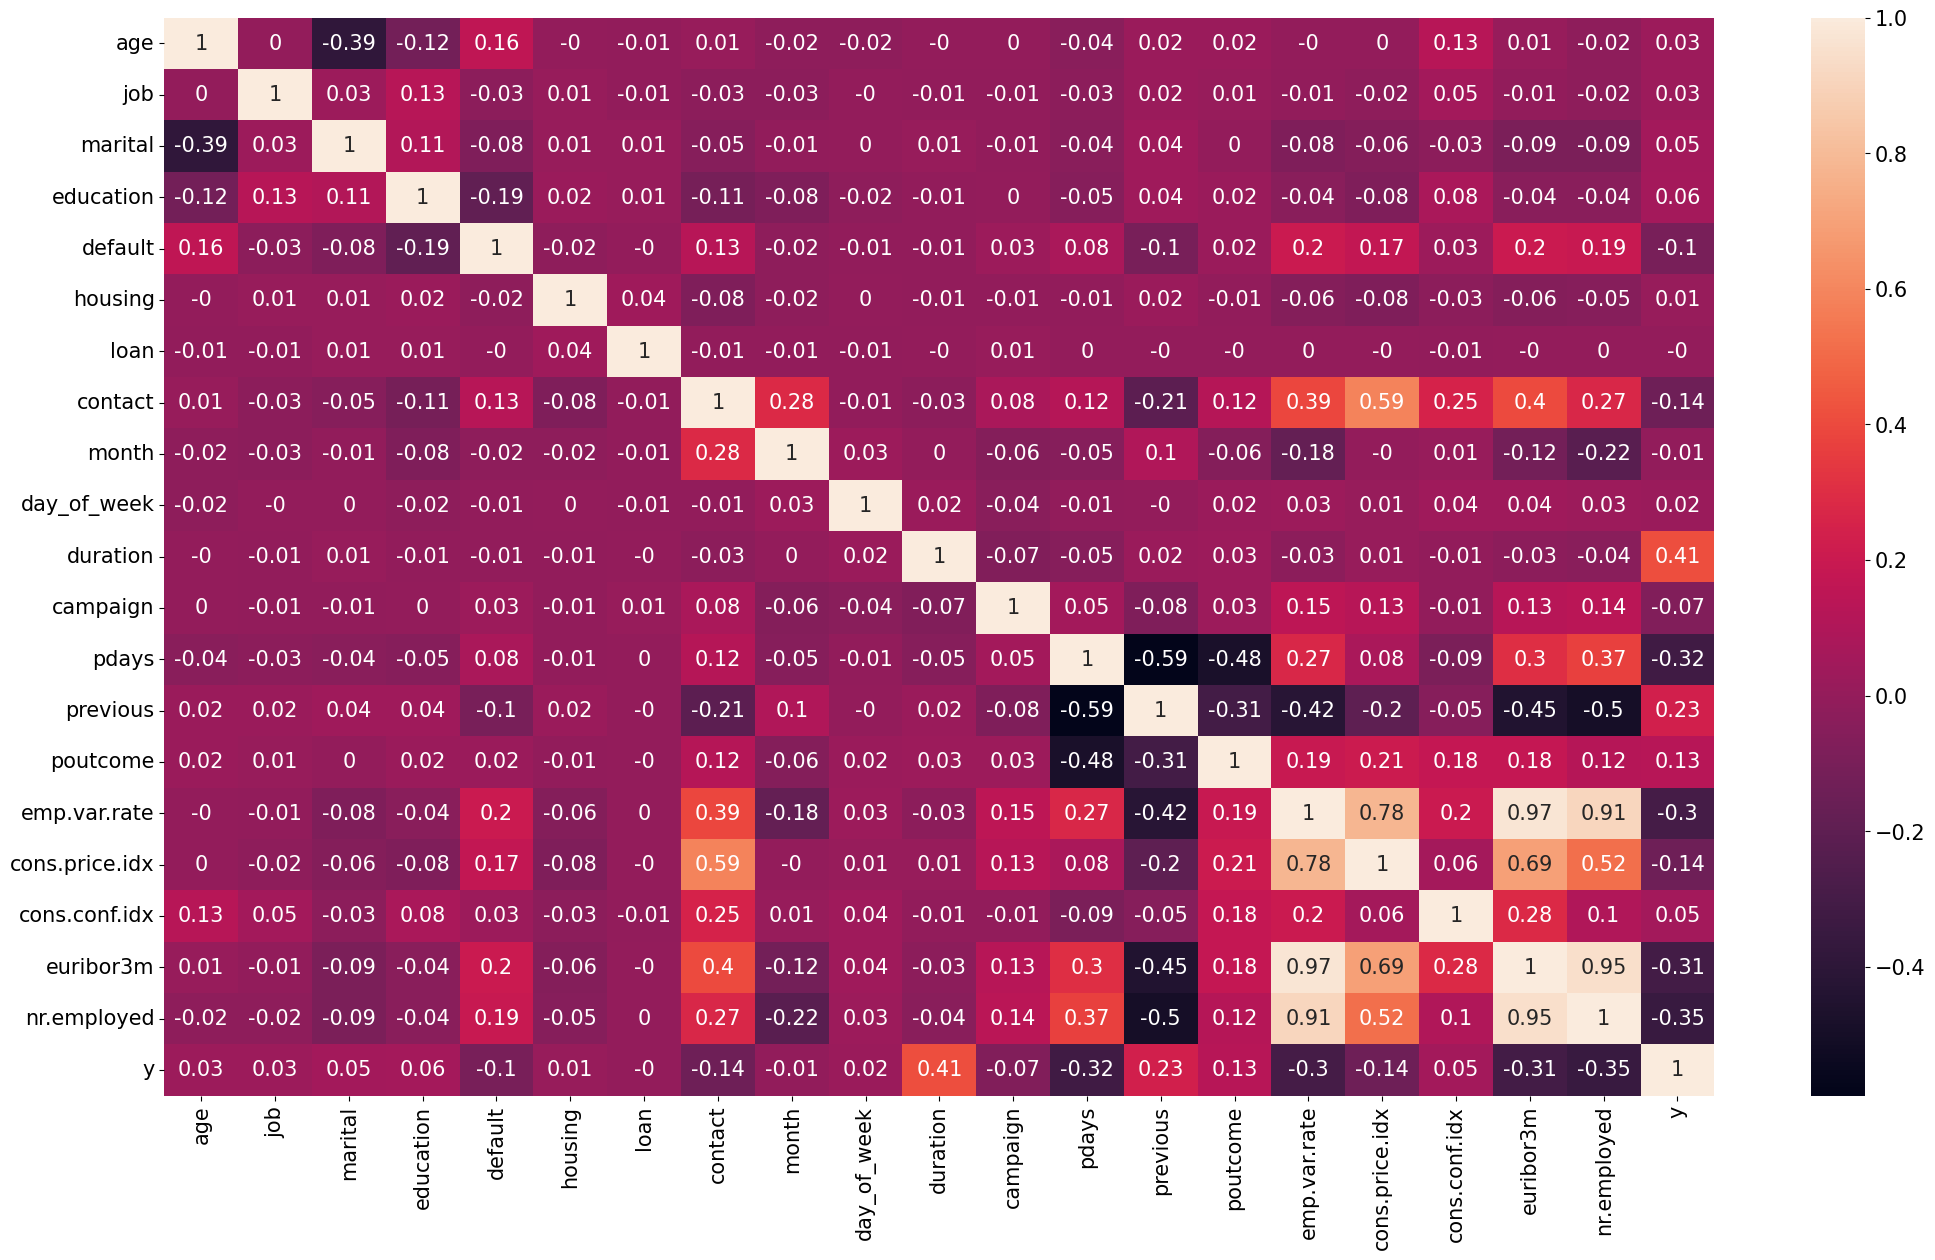

In [31]:
# Creating correlation heat map.
plt.figure(figsize=(25,14))
sns.heatmap(df_copy.corr(numeric_only=True).round(2), annot=True)
# Save the figure
plt.savefig("images/correlation_heatmap_all_features.png")

### <font color='purple'>Observations:</font>
   - The above plot shows four features are correlated but three of them (euribor3m, nr.employed, and emp.var.rate) have correlation values above the threshold of 0.9, indicating high multicollinearity. These features are not strongly correlated with the target variable (y) and has low variance

### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

In [32]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41096 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41096 non-null  int64  
 1   job             41096 non-null  int64  
 2   marital         41096 non-null  int64  
 3   education       41096 non-null  int64  
 4   default         41096 non-null  int64  
 5   housing         41096 non-null  int64  
 6   loan            41096 non-null  int64  
 7   contact         41096 non-null  int64  
 8   month           41096 non-null  int64  
 9   day_of_week     41096 non-null  int64  
 10  duration        41096 non-null  int64  
 11  campaign        41096 non-null  int64  
 12  pdays           41096 non-null  int64  
 13  previous        41096 non-null  int64  
 14  poutcome        41096 non-null  int64  
 15  emp.var.rate    41096 non-null  float64
 16  cons.price.idx  41096 non-null  float64
 17  cons.conf.idx   41096 non-null  floa

### Business Objective:

The business objective of the task is to predict whether a client will subscribe to a term deposit based on their demographic information and the results of previous marketing campaigns for a Portugese banking institution. 

The success of these campaigns is typically measured by the clients' decision to subscribe to the bank's products over the telephone. The task is to evaluate and compare the performance of different classification algorithms, including K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines. 

By comparing the performance of these classifiers, the aim is to identify the most effective algorithm for predicting which clients are more likely to subscribe to the bank's products, thus enabling the institution to optimize its marketing strategies and resource allocation for future campaigns. This information can be used by the bank to target their marketing efforts more effectively and increase their sales.

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features (columns 1 - 7), prepare the features and target column for modeling with appropriate encoding and transformations.

In [33]:
# Select the relevant features (columns 1 - 7) and the target column
X = df_copy.iloc[:, 0:7]  # Features
y = df_copy.y  # Target feature
X.head()

,age,job,marital,education,default,housing,loan
0,56,4,2,1,1,1,1
1,57,8,2,4,2,1,1
2,37,8,2,4,1,3,1
3,40,1,2,2,1,1,1
4,56,8,2,4,1,1,3


In [34]:
# Finding the percentage of positive and negative examples from normalized value counts
df_copy.y.value_counts(normalize = True)

y
0    0.88741
1    0.11259
Name: proportion, dtype: float64

In [35]:
# Scale/Normalize features(if needed)
# StandardScaler can be used to scale numeric features to have mean=0 and variance=1
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# Convert X_scaled back to a DataFrame
X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)
X_scaled.shape

(41096, 7)

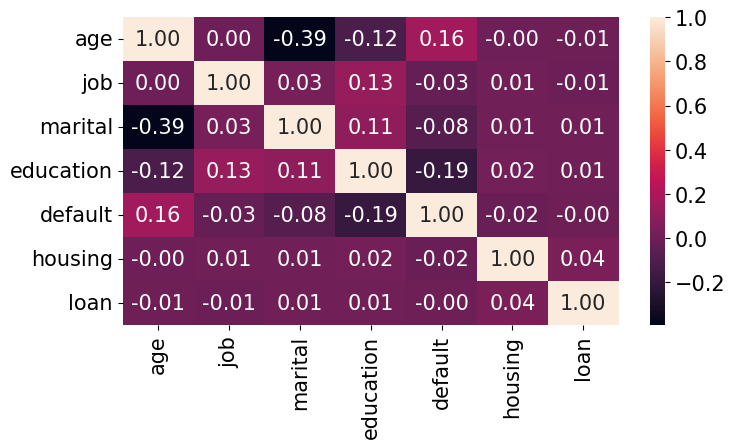

In [36]:
# Creating a correlation heatmap for scaled features
plt.figure(figsize=(8, 4))
sns.heatmap(X_scaled.corr(), annot=True, fmt='.2f')

# Save the figure
plt.savefig("images/scaled_correlation_heatmap.png")

plt.show()

### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [37]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=93, stratify = y)

In [38]:
# Print the counts of target variable (subscribed vs non-subscribed) from training set
print("counts of label '1': {}".format(sum(y_train == 1))) 
print("counts of label '0': {} \n".format(sum(y_train == 0))) 

counts of label '1': 3239
counts of label '0': 25528 



### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

In [39]:
y.value_counts(normalize = True)

y
0    0.88741
1    0.11259
Name: proportion, dtype: float64

### <font color='purple'>Observations:</font>
   - The baseline for the dataset is 0.88741, as determined by the value counts function and the target values outlined in the count plot. The model should be able to perform better than this baseline.
   - The feature overlapping in the dataset indicates that only 53% of the data can be properly classified, with the remaining 47% being classified arbitrarily. This means that the best possible accuracy that a model can achieve on this dataset is **77% (baseline)**, assuming that the dataset is balanced (i.e., there are equal numbers of positive and negative target values).

### <font color='purple'>Answer:</font>
   - The baseline performance that our classifier should aim to beat is **77%**

### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [40]:
models = {
    'Logistic Regression': LogisticRegression()
}

In [41]:
def evaluate_model(model_grid, X_train, y_train, X_test, y_test, model, model_name):   
    
    model_grid.fit(X_train, y_train)

    train_time = model_grid.cv_results_["mean_fit_time"][model_grid.best_index_]
    train_accuracy = model_grid.score(X_train, y_train)
    test_accuracy = model_grid.score(X_test, y_test)

    # Calculate precision, recall, f1, and balanced accuracy
    y_pred = model_grid.predict(X_test)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted', zero_division=1)
    balanced_accuracy = balanced_accuracy_score(y_test, y_pred)

    # Calculate inference time
    inference_time = np.mean(model_grid.cv_results_["mean_score_time"])

    results = {
        'Model': model_name,
        'Train Time': train_time,
        'Train Accuracy': train_accuracy,
        'Test Accuracy': test_accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Balanced Accuracy': balanced_accuracy,
        'Inference Time': inference_time
    }

    return results

In [42]:
def evaluate_models(models, X_train, y_train, X_test, y_test, suffix, params, cv, scorer, jobs):
    # Initialize lists to store results
    results = []
    plots = []
    
    for model_name, model in models.items():
        model_grid = GridSearchCV(model, param_grid=params.get(model_name), cv=cv, scoring=scorer, n_jobs=jobs)
        model_name_with_suffix = f"{model_name}_{suffix}"
        results.append(evaluate_model(model_grid, X_train, y_train, X_test, y_test, model, model_name))        
        plots.append({
            'Model Name': model_name,
            'Model': model_grid,
            'Image Name': model_name_with_suffix,
        })
        
    results_df = pd.DataFrame(results)
    plots_df = pd.DataFrame(plots)
    return results_df, plots_df
    

In [43]:
def plot_confusion_matrices_subplots(plots, X_test, y_test, figsize, image_name):
    # Create a figure and subplots
    fig, axes = plt.subplots(1, len(plots), figsize=figsize)

    # Plot the confusion matrices    
    for i, plot in plots.iterrows():
        model_name = plot['Model Name']
        model_grid = plot['Model']
        
        if len(plots) != 1: 
            ax=axes[i]
                    
        else:
            ax=axes            

        # Plot the confusion matrix
        cm_display = ConfusionMatrixDisplay.from_estimator(model_grid, X_test, y_test, 
                                                           display_labels=['No', 'Yes'], ax=ax)
        # Set the title and grid
        ax.set_title(f'{model_name}\nConfusion Matrix')
        ax.grid(False)        
    
    # Adjust layout and spacing
    plt.tight_layout()
    # Save the figure
    fig.savefig(f'{image_name}')
    #plt.show()


In [44]:
%%time

default_param_grids = {    
    'Logistic Regression': {        
        'C': [1.0]
    }    
}

model_name = 'Logistic Regression'
suffix = 'confusion_matrix_base.png'

lgr_results, lgr_plots  = evaluate_models(models, X_train, y_train, X_test, y_test, suffix,
                               default_param_grids, cv=5, scorer = 'recall', jobs=7)

CPU times: user 163 ms, sys: 131 ms, total: 294 ms
Wall time: 1.22 s


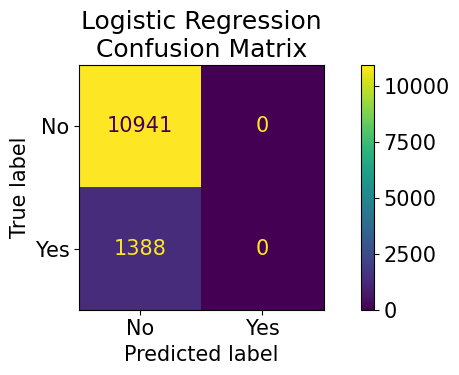

In [45]:
# Display all the saved plots
figsize=(8,4)
image_name = 'images/simple_model_logistic_regression.png'
plot_confusion_matrices_subplots(lgr_plots, X_test, y_test, figsize, image_name)

In [46]:
lgr_results

,Model,Train Time,Train Accuracy,Test Accuracy,Precision,Recall,F1-Score,Balanced Accuracy,Inference Time
0,Logistic Regression,0.081744,0.0,0.0,0.900094,0.88742,0.834487,0.5,0.00287


### <font color='purple'>Observations:</font>
   - The logistic regression model has a very low train accuracy and test accuracy, but a high precision and recall. 
   - This suggests that the model is very good at predicting the positive class, but not very good at predicting the negative class. 
   - The balanced accuracy is 0.5, which suggests that the model is performing no better than chance.

### Problem 9: Score the Model

What is the accuracy of your model?

In [47]:
print('Test Accuracy    :', lgr_results['Test Accuracy'][0])

Test Accuracy    : 0.0


### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

In [48]:
# Using four models with default values for the comparision.
models = {
    'KNN': KNeighborsClassifier(),
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),    
    'SVM': SVC()
}

default_param_grids = {
    'KNN': {
        'n_neighbors': [5]
    },
    'Logistic Regression': {
        'C': [1.0]
    },
    'Decision Tree': {        
        'min_samples_leaf': [1]
    },
    'SVM': {        
        'degree': [3]
    }
}

suffix = 'confusion_matrix_base_comparision.png'

# Evaluate each model
model_comp_results, model_comp_plots = evaluate_models(models, X_train, y_train, X_test, y_test, suffix, 
                                     default_param_grids, 5, 'recall', 7)


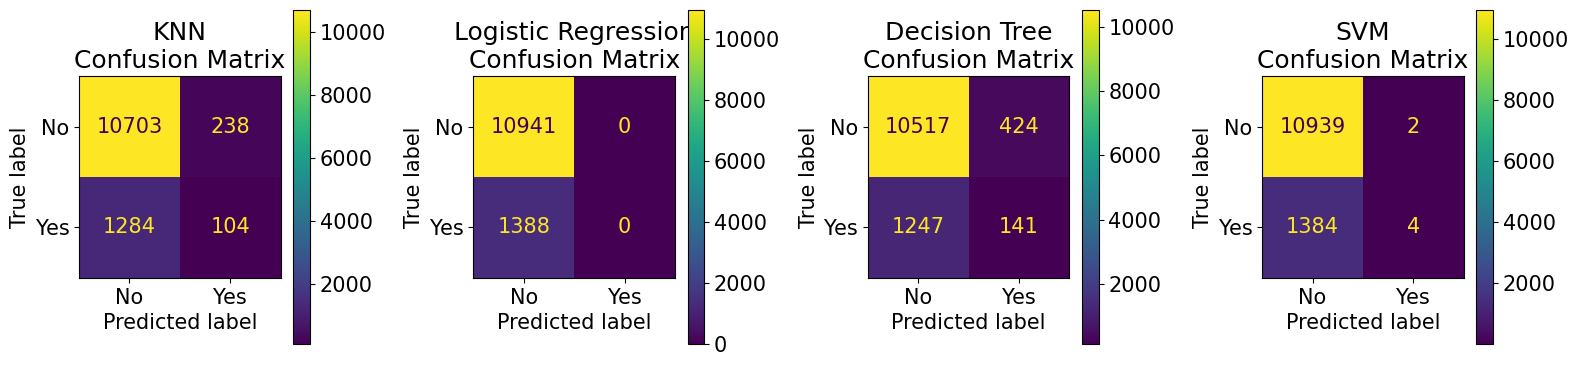

In [49]:
# Display all the saved plots
figsize=(16,4)
image_name = 'images/models_comparision_confusion_matrices_subplots.png'
plot_confusion_matrices_subplots(model_comp_plots, X_test, y_test, figsize, image_name)

In [50]:
model_comp_results

,Model,Train Time,Train Accuracy,Test Accuracy,Precision,Recall,F1-Score,Balanced Accuracy,Inference Time
0,KNN,0.017567,0.137079,0.074928,0.826598,0.876551,0.842047,0.526587,0.167694
1,Logistic Regression,0.009127,0.000000,0.000000,0.900094,0.887420,0.834487,0.500000,0.002627
2,Decision Tree,0.044930,0.299784,0.101585,0.821447,0.864466,0.838365,0.531416,0.006046
3,SVM,22.341190,0.003705,0.002882,0.862807,0.887582,0.835196,0.501350,1.902650


### <font color='purple'>Observations:</font>
  - None of the models perform particularly well in terms of accuracy, precision, or recall.
  - The Logistic Regression seems to be especially problematic, with zero training and test accuracy, precision, and recall.   
  - KNN achieved the highest test accuracy and F1-score but the longest inference time but it still has relatively low accuracy overall.    
  - Decision Tree shows a moderate test accuracy but performs better than Logistic Regression and SVM.
  - Logistic Regression and SVM have very low train and test accuracy, indicating that they may not be suitable for this task.
  - **The low accuracy in general suggests that more advanced models or additional feature engineering may be required to improve model performance.**

### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

### <font color='purple'>Dataset Cleanup</font>
   - The correlation matrix above shows strong correlations among the following features:
        - poutcome is negatively correlated with pdays and positively correlated with previous.
        - emp.var.rate is positively correlated with cons.price.idx, euribor3m, and nr.employed.   
   - We should drop the "duration" variable because its value is only known after the call ends, making it unrealistic for prediction modeling. Also it's highly correlated with the target variable.

In [51]:
X, y = df_copy.drop(['duration', 'pdays', 'previous', 'cons.price.idx', 'euribor3m', 'nr.employed', 'y'], axis=1), df_copy.y
X.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,poutcome,emp.var.rate,cons.conf.idx
0,56,4,2,1,1,1,1,2,7,2,1,2,1.1,-36.4
1,57,8,2,4,2,1,1,2,7,2,1,2,1.1,-36.4
2,37,8,2,4,1,3,1,2,7,2,1,2,1.1,-36.4
3,40,1,2,2,1,1,1,2,7,2,1,2,1.1,-36.4
4,56,8,2,4,1,1,3,2,7,2,1,2,1.1,-36.4


In [52]:
def feature_importance(X, y):
    # Calculate feature importance
    model = Ridge(alpha = 0.0000001).fit(X, y)
    feature_importances = permutation_importance(model, X, y, n_jobs=3)

    # Create a DataFrame of feature importances
    feature_importances_df = pd.DataFrame({
        'feature': X.columns,
        'importance': feature_importances.importances_mean
    })

    # Sort the DataFrame by importance in descending order
    return feature_importances_df.sort_values(by='importance', ascending=False)
    
# Find the feature importance
feature_importance(X, y)

,feature,importance
12,emp.var.rate,0.221781
11,poutcome,0.064255
13,cons.conf.idx,0.017400
8,month,0.003868
7,contact,0.002762
0,age,0.002082
4,default,0.002007
2,marital,0.001206
9,day_of_week,0.000932
3,education,0.000675


### <font color='purple'>Observations:</font>

   **High Positive Importance:** 'emp.var.rate', 'poutcome', 'cons.conf.idx': These columns have positive permutation importance values, suggesting that shuffling their values significantly decreases the model's performance. These features are considered important for the model's predictions.

   **Low Positive Importance:** 'month', 'contact', 'cons.price.idx', 'default', 'age', 'marital': These columns have relatively lower positive permutation importance values. While they still contribute to the model's performance, their importance might be somewhat lower compared to the columns with higher positive importance.

   **Low to Negative Importance(Low or Near-Zero Contribution):** 'day_of_week', 'campaign', 'education', 'job', 'housing', 'loan': These columns have importance values ranging from low to negative. Negative values indicate that shuffling these feature values actually improves the model's performance. This could imply that these features might not carry strong predictive power in the current model.

In [53]:
# Find variance inflation factor
def VIF(X):
    # Calculate the VIF for each feature
    vif = [variance_inflation_factor(X, i) for i in range(X.shape[1])]

    # Create a DataFrame with the VIF values
    vif_df = pd.DataFrame({'Feature': X.columns, 'VIF': vif})

    # Sort the DataFrame by VIF
    return vif_df.sort_values(by='VIF', ascending=False)


VIF(X)

,Feature,VIF
13,cons.conf.idx,40.515276
11,poutcome,25.944140
0,age,15.793035
2,marital,14.587947
7,contact,12.208873
4,default,10.627475
8,month,7.372713
3,education,6.041608
9,day_of_week,5.495132
5,housing,5.389121


### <font color='purple'>Observations:</font>
    
   **High VIF:** 
         
   'cons.price.idx', 'poutcome', 'age', 'marital', 'contact', 'default'. These variables have relatively high VIF values, suggesting strong multicollinearity with other variables in the dataset, which could affect the stability and interpretability of a regression model.

   **Moderate VIF:**

   'month', 'education', 'day_of_week', 'housing'. These variables have moderate VIF values, indicating some degree of multicollinearity. While not as severe as high VIF values, it's still worth considering their correlations and potential impact on the model.

   **Low VIF:**

   'loan', 'job', campaign', 'emp.var.rate'. Features with low VIF values indicate lower multicollinearity, which is generally preferable.

In [54]:
scaler=MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [55]:
# L1 Regularization to Select Features
# Define a list of C values
Cs = np.logspace(-5, 0.5, num=50)  # Adjust the number of values as needed

penalty='l1'
solver='liblinear'
max_iter=1000
random_state=42

# Build the coefficient list
coef_list = []
for Cval in Cs:
    lgr = LogisticRegression(penalty=penalty, 
                             solver=solver,
                             C=Cval, 
                             random_state=random_state, 
                             max_iter=max_iter)
    lgr.fit(X_scaled, y)
    coef_list.append(list(lgr.coef_[0]))

# Build the DataFrame
coef_df = pd.DataFrame(coef_list, columns=X.columns, index=Cs)
coef_df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,poutcome,emp.var.rate,cons.conf.idx
0.000010,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.000013,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.000017,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.000022,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0.000028,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


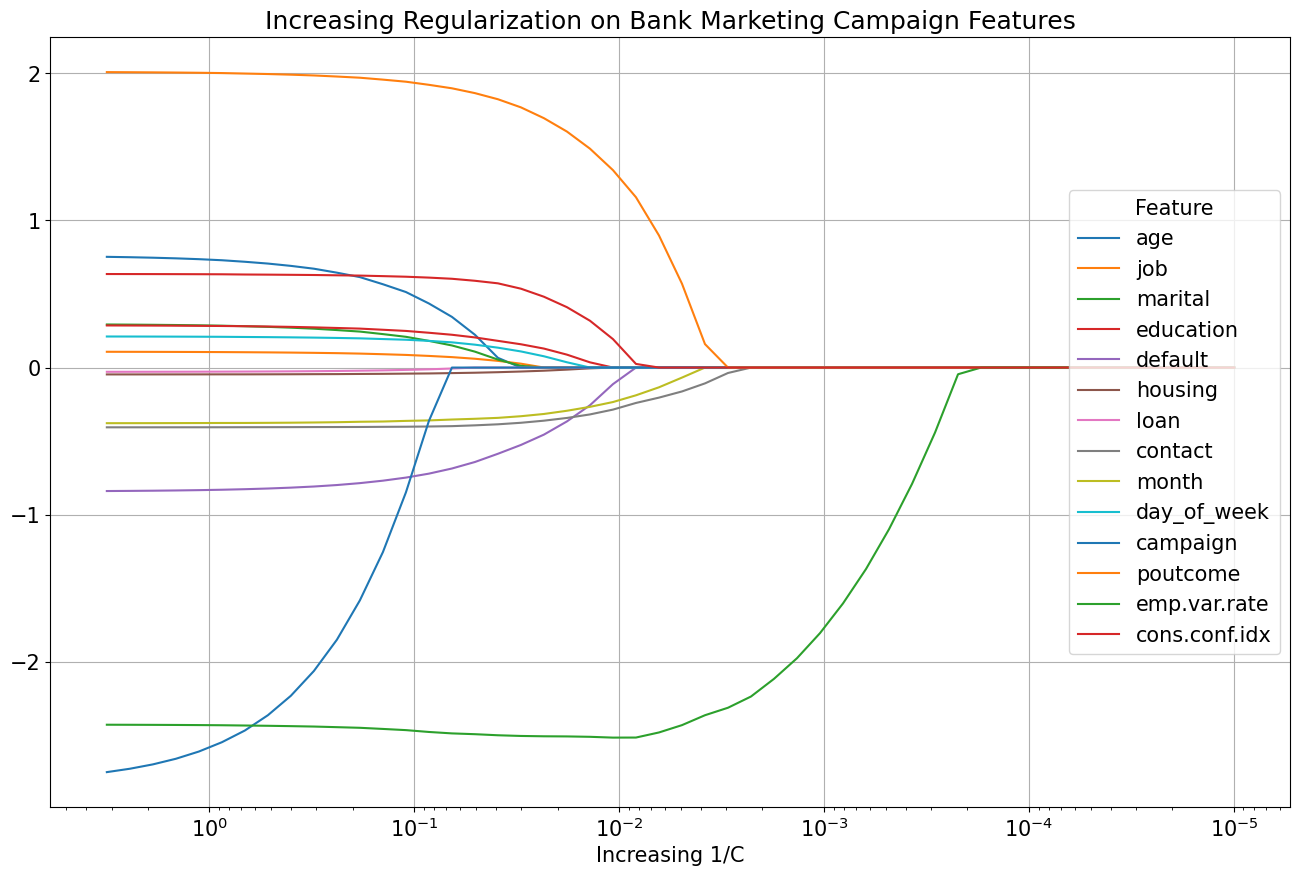

In [56]:
# Create a new figure with a larger size
plt.figure(figsize=(16, 10))

# # Select the top 10 features
# coef_df_top = coef_df.iloc[:, :15]

# Plot the coefficients on a semilogarithmic scale
plt.semilogx(coef_df)

# Invert the x-axis to show increasing regularization
plt.gca().invert_xaxis()

# Add a grid
plt.grid(True)

# Add a legend
plt.legend(list(coef_df.columns), title="Feature", loc='center right')

# Add a title and x-axis label
plt.title("Increasing Regularization on Bank Marketing Campaign Features")
plt.xlabel("Increasing 1/C")

# Save the plot as an image
plt.savefig("images/coefficient.png")

### <font color='purple'>Observations:</font>
   
   - The features age, job, education, and campaign have very long lines, which indicates that they have a strong relationship with the target variable. However, the direction of the lines is negative, which means that they are inversely correlated with the target variable. This means that as the values of these features increase, the probability of churn decreases.
   - The following features have relatively short lines, which indicates that they have a weaker relationship with the target variable:    
     - marital
     - default
     - housing
     - loan
     - contact
     - month
     - day_of_week
     - emp.var.rate
     - cons.conf.idx

In [57]:
# Check to see if L1 regulation would remove any of less important features
selector = SelectFromModel(estimator=LogisticRegression(C = 0.01, penalty = 'l1', max_iter = 1000,
                                                        solver = 'liblinear', random_state = 42)).fit(X, y)
# top features by L1 regulation
print(selector.get_feature_names_out(X.columns))

['age' 'job' 'education' 'default' 'housing' 'contact' 'month'
 'day_of_week' 'campaign' 'poutcome' 'emp.var.rate' 'cons.conf.idx']


### <font color='purple'>Observations:</font>
   - Based on Feature Importance, Variance Inflation Factor, L1 regularization below features are less important and can be removed.   
        - cons.conf.idx
        - poutcome
        - housing
        - loan
        - contact
        - month
        - day_of_week
        - emp.var.rate

In [58]:
# The dataset is imbalanced having 11% acceptance and 89% not. 
# Apply SMOTE to have equal number of data entries on either classes. 
# Standardization is applied to avoid small features penalized heavily by the penalty term since features are skewed.

from imblearn.over_sampling import SMOTE
from collections import Counter

# Print the class distribution before applying SMOTE
print("Class distribution before SMOTE:", Counter(y))

# Initialize the SMOTE object
smote = SMOTE(random_state=42)

# Initialize the StandardScaler
scaler = MinMaxScaler()

# Apply SMOTE to balance the classes
X, y = smote.fit_resample(X, y)

# Print the class distribution after applying SMOTE
print("Class distribution after SMOTE:", Counter(y))

# Fit and transform the scaled features
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

Class distribution before SMOTE: Counter({0: 36469, 1: 4627})
Class distribution after SMOTE: Counter({0: 36469, 1: 36469})


In [59]:
# Dropping loan, housing and day_of_week
X_scaled.drop(['loan', 'housing', 'day_of_week'], axis=1, inplace=True)

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y,
                                                    random_state = 42, test_size = 0.2, stratify = y)

In [61]:
models = {
    'KNN': KNeighborsClassifier(),
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),    
    'SVM': SVC()
}

default_param_grids = {
    'KNN': {
        'n_neighbors': range(3, 19, 2), 
        'weights':['uniform', 'distance'], 
        'p':[1, 2], 
        'n_jobs':[5]
    },
    'Logistic Regression': {
        'solver':['lbfgs', 'liblinear'], 
        'C':[0.001, 0.01, 0.1, 1, 10, 100, 1000], 
        'max_iter':[1000]
    },
    'Decision Tree': {
         'max_depth': [5, 11, 17, 23, 29, 33, 39, 43, 49],
         'min_samples_split': [0.00001, 0.0001, 0.001, 0.01],
         'criterion': ['gini', 'entropy'],
         'min_samples_leaf': [2, 3, 5]        
    },
    'SVM': {        
        'kernel': ['rbf', 'linear'], 
        'gamma': ['scale', 'auto'], 
        'C':[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000], 
        'max_iter': [5000],
        'cache_size':[1000]
    }
}

suffix = 'confusion_matrix_improved_comparision.png'
# I have tried all scoring strategies ['accuracy', 'precision', 'recall', 'roc_auc']
scorer = 'roc_auc'

# Evaluate each model
imp_model_comp_results, imp_model_comp_plots = evaluate_models(models, X_train, y_train, X_test, y_test, suffix, 
                                     default_param_grids, 5, scorer, 7)


/home/aiuser/anaconda3/envs/ai_env/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/aiuser/anaconda3/envs/ai_env/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/aiuser/anaconda3/envs/ai_env/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/aiuser/anaconda3/envs/ai_env/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/home/ai

/home/aiuser/anaconda3/envs/ai_env/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/aiuser/anaconda3/envs/ai_env/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/aiuser/anaconda3/envs/ai_env/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/aiuser/anaconda3/envs/ai_env/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/aiuser/anaconda3/envs/ai_env/lib/p

/home/aiuser/anaconda3/envs/ai_env/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/aiuser/anaconda3/envs/ai_env/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/aiuser/anaconda3/envs/ai_env/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/aiuser/anaconda3/envs/ai_env/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/aiuser/anaconda3/envs/ai_env/lib/p

/home/aiuser/anaconda3/envs/ai_env/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/aiuser/anaconda3/envs/ai_env/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/aiuser/anaconda3/envs/ai_env/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/aiuser/anaconda3/envs/ai_env/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/aiuser/anaconda3/envs/ai_env/lib/p

/home/aiuser/anaconda3/envs/ai_env/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/aiuser/anaconda3/envs/ai_env/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/aiuser/anaconda3/envs/ai_env/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/aiuser/anaconda3/envs/ai_env/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/home/aiuser/anaconda3/envs/ai_env/lib/p

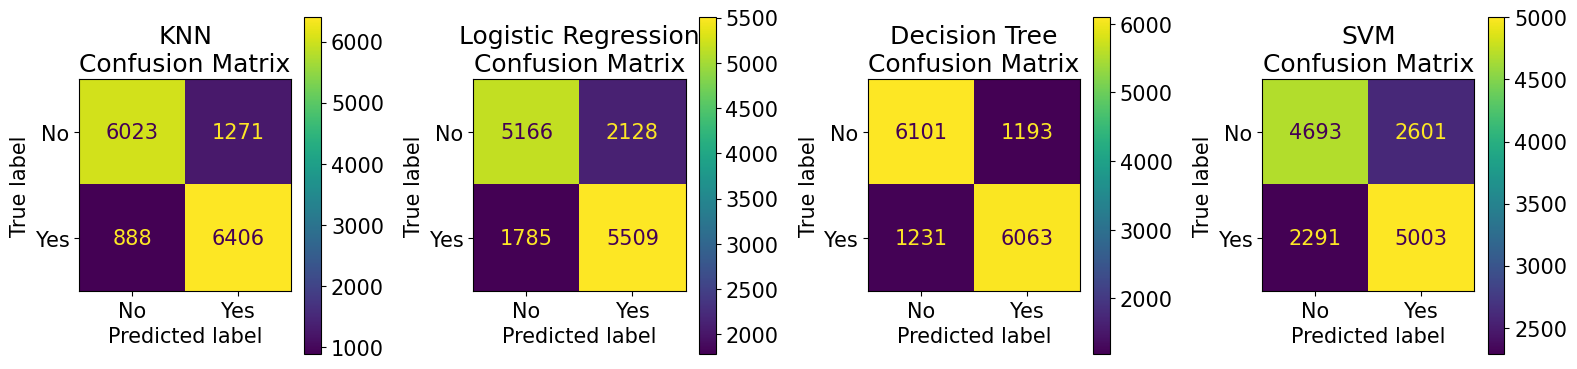

In [62]:
# Display all the saved plots
figsize=(16,4)
image_name = 'images/improved_models_comparision_confusion_matrices_subplots.png'
plot_confusion_matrices_subplots(imp_model_comp_plots, X_test, y_test, figsize, image_name)

In [63]:
imp_model_comp_results

,Model,Train Time,Train Accuracy,Test Accuracy,Precision,Recall,F1-Score,Balanced Accuracy,Inference Time
0,KNN,0.194865,0.993903,0.913771,0.852975,0.852002,0.851900,0.852002,2.075588
1,Logistic Regression,0.203484,0.804542,0.807799,0.732279,0.731766,0.731617,0.731766,0.009409
2,Decision Tree,0.138866,0.966049,0.906018,0.833845,0.833836,0.833835,0.833836,0.011962
3,SVM,38.575899,0.713415,0.719193,0.664954,0.664656,0.664504,0.664656,7.403238


### <font color='purple'>Model Results:</font>
   - KNN had the best performance of the four models in terms of test accuracy and F1-Score, but it had the high inference time.
   - The decision tree model has the second highest train and test accuracy, precision, recall, F1-score, and balanced accuracy. It has a relatively short training time and inference time compared to the KNN and SVM models.  
   - The logistic regression model has the shortest inference time, but also the lowest test accuracy and F1-score.
   - The SVM model has the longest train time and high inference time
   - **The Decision Tree model is a good choice if we prioritize a trade-off between model performance and computational efficiency.**

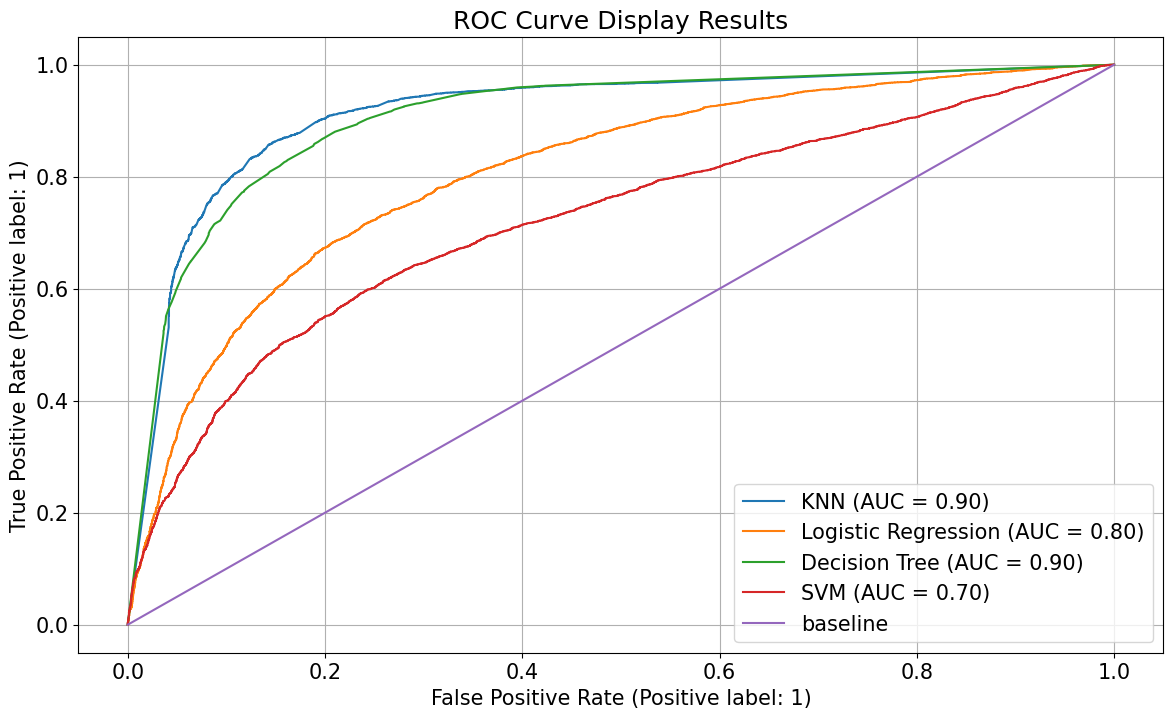

CPU times: user 6.94 s, sys: 426 ms, total: 7.36 s
Wall time: 4.34 s


In [65]:
%%time
# ROC Curve Plot
fig, ax = plt.subplots(figsize=(14, 8))

for i, plot in imp_model_comp_plots.iterrows():
    model_name = plot['Model Name']
    model_grid = plot['Model']                  
    RocCurveDisplay.from_estimator(model_grid, X_test, y_test, pos_label=1, ax=ax,
                                   label=f'{model_name} (AUC = {model_grid.best_score_:.2f})')

plt.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), label='baseline')
plt.title('ROC Curve Display Results')
plt.legend()
plt.grid(True)
plt.show()

##### Questions

### <font color='purple'>What are the next steps?</font>
   - I showed that some values in the data are missing or unknown. The job and marital columns are very important for the models. We should delete these columns from the data and test the models again.
   - Next, we should fix the features that overlap or repeat in the data. This can confuse the models and make them less accurate. After we fix this, we should check the models again and see if they improve.
   - We could also use SVM with a different type of kernel and higher degrees. But this would take a lot of computing power and time. We should use a separate computer for this.